In [1]:
!pip install gym==0.26.2
!pip install numpy==1.23.5

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.11/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [22]:
#import modules

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import random

from collections import deque

import matplotlib.pyplot as plt



**Question1**

In [3]:
#create the  environment
env = gym.make('MountainCar-v0', render_mode = "rgb_array")
#env = gym.make('MountainCar-v0', render_mode='human') **for rendering it locally in order to have the graphical environment in colab does not work, also the render_mode='human' significaly increas the time of execution**

# Observation and action spaces
print('Observation space:', env.observation_space)
print('action space:', env.action_space)

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Discrete(3)


https://www.gymlibrary.dev/environments/classic_control/mountain_car/

**Action space.**
The action space is Discrete(3). This means there are 3 discrete actions available to the agent are:
0: Accelerate to the left
1: Don't accelerate
2: Accelerate to the right

**Observation space.**
The observation space is Box(2,). This means the environment provides the agent with a 2-dimensional continuous state vector. The state vector contains:
0: position of the car along the x-axis
1: velocity of the car


**Reward signals.**
The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep that does not reach the flag


In [4]:
#initialize the environment
observation = env.reset(seed=42)[0]

for step in range(100):
    #render the environment
    env.render()

    # Take a random action
    action = env.action_space.sample()  # Randomly choose between 0 (left) and 1 (right)
    observation, reward, terminated, truncated, info = env.step(action)

    print(f"Step {step + 1}:")
    print(f"  Observation: {observation}")
    print(f"  Reward: {reward}")
    print(f"  Terminated: {terminated}, Truncated: {truncated}")

    if terminated or truncated:  # End the episode if done
        print("Episode finished after {} steps.".format(step + 1))
        break

# Close the environment
env.close()



Step 1:
  Observation: [-0.44679132 -0.00158252]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 2:
  Observation: [-0.4499448  -0.00315349]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 3:
  Observation: [-0.45464623 -0.00470141]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 4:
  Observation: [-0.45886108 -0.00421488]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 5:
  Observation: [-0.46255845 -0.00369736]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 6:
  Observation: [-0.46671107 -0.00415261]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 7:
  Observation: [-0.47128826 -0.0045772 ]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 8:
  Observation: [-0.47725618 -0.00596792]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 9:
  Observation: [-0.48257056 -0.00531437]
  Reward: -1.0
  Terminated: False, Truncated: False
Step 10:
  Observation: [-0.48919186 -0.00662131]
  Reward: -1.0
  Terminated: Fal

**Question2**

In [5]:
#define the dqn neural network architecture

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad():
            return policy_net(state).argmax().item()  # Exploit

In [18]:
#initialize hyperparameters
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update = 10
memory_capacity = 10000
learning_rate = 0.001
num_episodes = 1000

# Get number of actions and state size
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Create the policy network and target network
policy_net = DQN(state_dim, n_actions)
target_net = DQN(state_dim, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer and replay memory
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayMemory(memory_capacity)

In [19]:
# Training Loop
epsilon = epsilon_start
rewards=[]
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    total_reward = 0

    for t in range(200): #the environment allows max 200 steps   
        # Select and perform an action
        action = select_action(state, policy_net, epsilon)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Combine termination and truncation

        total_reward += reward

        # Convert to torch tensors
        next_state = torch.tensor([next_state], dtype=torch.float32)
        action = torch.tensor([[action]])
        reward = torch.tensor([reward])

        # Store transition in replay memory
        memory.push((state, action, next_state, reward, done))
        state = next_state

        # Sample mini-batch from replay memory
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

            # Convert batch to tensors
            batch_state = torch.cat(batch_state)
            batch_action = torch.cat(batch_action)
            batch_reward = torch.cat(batch_reward)
            batch_next_state = torch.cat(batch_next_state)
            batch_done = torch.tensor(batch_done, dtype=torch.float32)

            # Compute Q(s, a) with policy network
            current_q_values = policy_net(batch_state).gather(1, batch_action)

            # Compute target Q values with target network
            next_q_values = target_net(batch_next_state).max(1)[0].detach()
            target_q_values = batch_reward + (gamma * next_q_values * (1 - batch_done))

            # Compute loss and optimize
            loss = nn.functional.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update target network periodically
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decrease epsilon for less exploration over time
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if done:
          rewards.append(total_reward)
          break

    print(f"Episode {episode} - Total Reward: {total_reward}")

Episode 0 - Total Reward: -200.0
Episode 1 - Total Reward: -200.0
Episode 2 - Total Reward: -200.0
Episode 3 - Total Reward: -200.0
Episode 4 - Total Reward: -200.0
Episode 5 - Total Reward: -200.0
Episode 6 - Total Reward: -200.0
Episode 7 - Total Reward: -200.0
Episode 8 - Total Reward: -200.0
Episode 9 - Total Reward: -200.0
Episode 10 - Total Reward: -200.0
Episode 11 - Total Reward: -200.0
Episode 12 - Total Reward: -200.0
Episode 13 - Total Reward: -200.0
Episode 14 - Total Reward: -200.0
Episode 15 - Total Reward: -200.0
Episode 16 - Total Reward: -200.0
Episode 17 - Total Reward: -187.0
Episode 18 - Total Reward: -200.0
Episode 19 - Total Reward: -200.0
Episode 20 - Total Reward: -200.0
Episode 21 - Total Reward: -200.0
Episode 22 - Total Reward: -200.0
Episode 23 - Total Reward: -200.0
Episode 24 - Total Reward: -200.0
Episode 25 - Total Reward: -200.0
Episode 26 - Total Reward: -200.0
Episode 27 - Total Reward: -200.0
Episode 28 - Total Reward: -200.0
Episode 29 - Total Rewar

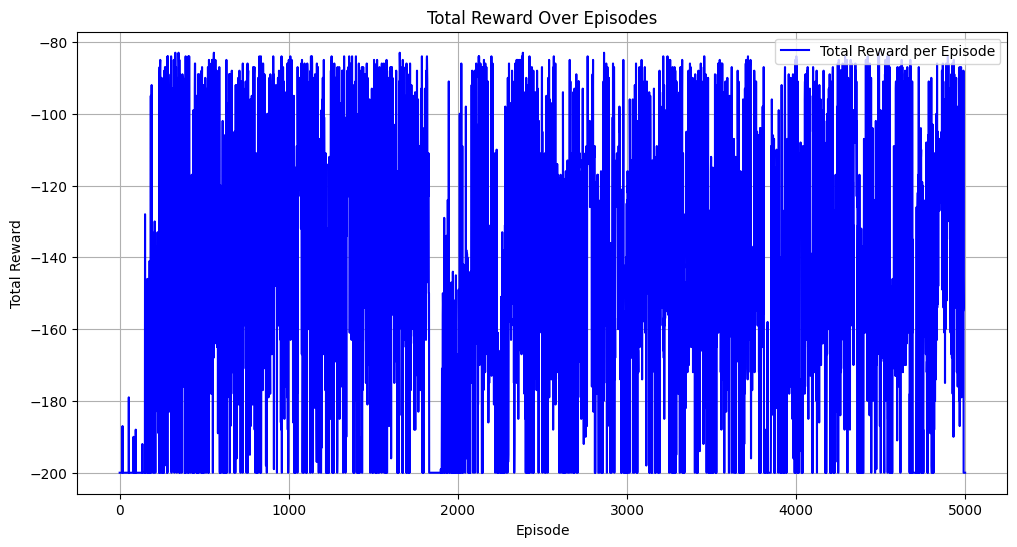

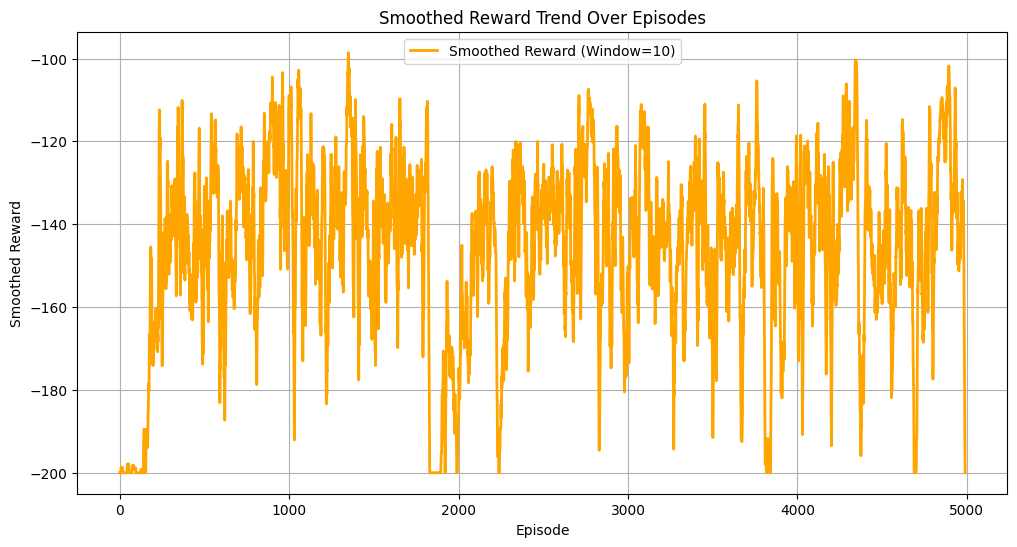

In [24]:
#reward plots

# Function to smooth the reward curve
def smooth_rewards(rewards, window_size=10):
    smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    return smoothed

# Compute smoothed rewards
smoothed = smooth_rewards(rewards)

# Plotting raw rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Total Reward per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Over Episodes")
plt.legend()
plt.grid()
plt.show()

# Plotting smoothed rewards
plt.figure(figsize=(12, 6))
plt.plot(range(len(smoothed)), smoothed, label=f"Smoothed Reward (Window={10})", color="orange", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Smoothed Reward Trend Over Episodes")
plt.legend()
plt.grid()
plt.show()

ειπε να το τρεξουμε μεχρι περιπου να συγγλινει το ετρεξα μεχρι 10.000 και η φαση επαναλαβμανεται περιπου καθε 500+ οποτε το εβαλα στα 1000

γενικα τα αποτελεσματα εχουν μια περιοδο που βελτιωνοντε και μετα πεφτουν, οπως φενεται με παραθυρο 10 τα καλυτερα που πιανουν ειναι λιγο καλυτερα απο -100, τα καλύτερα μεμονομενα επισοδεια ειναι στο -80+ κατι (καθε time stap που δεν φτανει στο τερματισμο ειναι -1)

